<a href="https://colab.research.google.com/github/alexliqu09/Pix2Pix/blob/main/pix2pix_flower_Black_white.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Usando el Data set que de flores Brindado**

## **Librerías para poder navegar por el drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt


## **Librerias para poder convertir imagenes de blanco y negro a color**

In [ ]:
from PIL import Image
import os

In [ ]:
'''
def gray(ruta_img_color,ruta_imag_salida):
    name_image=os.listdir(ruta_img_color)
    for image in name_image:
        img=Image.open(ruta_img_color + '/' + image).convert('L')
        img.save(ruta_imag_salida +'/' + image)
'''
#gray(Color,BW)

In [ ]:
PATH="/content/drive/My Drive/dataset/data_flor/data"

In [ ]:
#RUTA DE ENTRADA
INPATH=PATH + '/gris'
#RUTA DE SALIDA
OUTPATH=PATH + '/target'
#RUTA DE  GUARDADO PARA EN CASO DE QUE EL SISTEMA FALLE
CHKPATH=PATH + '/checkpoint'


In [ ]:
imgurls= !ls -1 "{INPATH}"


In [ ]:
n=500

train_n=round(n*0.8 )

#randorimzamos lo siguiente
randulrs=np.copy(imgurls)

np.random.shuffle(randulrs)
#partimos
tr_urls=randulrs[:train_n]
ts_urls=randulrs[train_n:n]

print(len(imgurls),len(tr_urls),len(ts_urls))

500 400 100


# **CREACIÓN DE FUNCIONES DE REDIMENZIONAR**

In [ ]:
IMG_WIDTH=256
IMG_HEIGHT=256

def resize(inimage, tgimage, height, width):
  inimage = tf.image.resize(inimage, [height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  tgimage = tf.image.resize(tgimage, [height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return inimage, tgimage

# normalizing the images to [-1, 1]

def normalize(inimage, tgimage):
  inimage = (inimage / 127.5) - 1
  tgimage = (tgimage / 127.5) - 1

  return inimage, tgimage

@tf.function()
def random_jitter(inimage, tgimage):
  # resizing to 286 x 286 x 3
  inimage, tgimage = resize(inimage, tgimage, 286, 286)
  stacked_image=tf.stack([inimage,tgimage],axis=0)
  cropped_image=tf.image.random_crop(stacked_image,size=[2,IMG_HEIGHT,IMG_WIDTH,3])
  inimage,tgimage=cropped_image[0],cropped_image[1]

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    inimage = tf.image.flip_left_right(inimage)
    tgimage = tf.image.flip_left_right(tgimage)

  return inimage, tgimage

def load_image(filename,augument=True):
    inimage=tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH +'/' + filename)),tf.float32)[...,:3]
    tgimage=tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH +'/' + filename)),tf.float32)[...,:3]
    inimage,tgimage=resize(inimage,tgimage,IMG_WIDTH,IMG_HEIGHT)

    if augument:
        inimage,tgimage=random_jitter(inimage, tgimage)

    inimage,tgimage=normalize(inimage, tgimage)

    return   inimage,tgimage

## **Funciones para cargar imagenes de entrenamiento y testeo**

In [ ]:
def load_train_image(filename):
    return load_image(filename,True)
def load_test_image(filename):
    return load_image(filename,False)

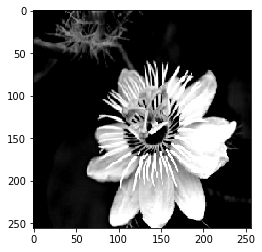

In [ ]:
plt.imshow((load_train_image(randulrs[0])[0]+1)/2)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(4)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(4)


In [ ]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters,apply_batchnorm=True):
    result = Sequential ()
    initializer= tf.random_normal_initializer(0,0.02)
    result.add(Conv2D(filters,
                      kernel_size=4,
                      strides=2,
                      padding="same",
                      kernel_initializer=initializer,
                      use_bias=not apply_batchnorm))


    if apply_batchnorm:
        result.add(BatchNormalization())#

    result.add(LeakyReLU())

    return result

downsample(64)

In [ ]:
def upsample(filters,apply_dropout=False):
    result = Sequential ()
    initializer= tf.random_normal_initializer(0,0.02)
    result.add(Conv2DTranspose(filters,
                               kernel_size=4,
                               strides=2,
                               padding="same",
                               kernel_initializer=initializer,
                               use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))#

    result.add(ReLU())

    return result

upsample(64)

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[None,None,3])

  down_stack = [
    downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128), # (bs, 64, 64, 128)
    downsample(256), # (bs, 32, 32, 256)
    downsample(512), # (bs, 16, 16, 512)
    downsample(512), # (bs, 8, 8, 512)
    downsample(512), # (bs, 4, 4, 512)
    downsample(512), # (bs, 2, 2, 512)
    downsample(512), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512), # (bs, 16, 16, 1024)
    upsample(256), # (bs, 32, 32, 512)
    upsample(128), # (bs, 64, 64, 256)
    upsample(64), # (bs, 128, 128, 128)
  ]
  initializer=tf.random_normal_initializer(0,0.02)
  last=Conv2DTranspose(filters=3,
                     kernel_size=4,
                     strides=2,
                     padding="same",
                     kernel_initializer=initializer,
                     activation="tanh")
  x=inputs
  s=[]
  concat= Concatenate()
  for down in down_stack:
      x = down(x)
      s.append(x)

  s = reversed(s[:-1])

  for up,sk in zip(up_stack,s):
       x = up(x)
       x = concat([x,sk])

  last=last(x)

  return Model(inputs=inputs,outputs=last)

generator=Generator()

In [ ]:
def Disciminator():
    ini = Input([None,None,3],name="imput_img")
    gen = Input([None,None,3],name="gener_img")
    con= concatenate([ini,gen])
    initializer=tf.random_normal_initializer(0,0.2)
    down1=downsample(64, apply_batchnorm=False)(con)
    down2=downsample(128)(down1)
    down3=downsample(256)(down2)
    down4=downsample(512)(down3)
    last=tf.keras.layers.Conv2D(filters=1,
                                 kernel_size=4,
                                 strides=1,
                                 padding="same",
                                 kernel_initializer=initializer)(down4)
    return tf.keras.Model(inputs=[ini,gen],outputs=last)

discriminator=Disciminator()

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_ouput,disc_generated_ouput):
    real_loss=loss_object(tf.ones_like(disc_real_ouput),disc_real_ouput)
    generated_loss=loss_object(tf.zeros_like(disc_real_ouput),disc_real_ouput)
    total_disc_loss=real_loss + generated_loss

    return total_disc_loss



In [ ]:
LAMBDA=100
def generator_loss(disc_generated_ouput,gen_ouput,target):

    gan_loss=loss_object(tf.ones_like(disc_generated_ouput),disc_generated_ouput)


    l1_loss=tf.reduce_mean(tf.abs(target-gen_ouput))

    total_gen_loss=gan_loss + (LAMBDA*l1_loss)

    return total_gen_loss

In [ ]:
import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CHKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
def generate_images(model,test_input,tar,save_filename=False,display_imgs=True):
    prediction=model(test_input,training=True)
    if save_filename:
        tf.keras.preprocessing.image.save_img(PATH +'/ouput/'+ save_filename +'.jpg',prediction[0,...])
    plt.figure(figsize=(10,10))
    display_list=[test_input[0],tar[0],prediction[0]]
    title=['Input Image','Ground truth','Predicted Image']

    if display_imgs:
        for i in range(3):
            plt.subplot(1,3,i+1)
            plt.title(title[i])
            plt.imshow(display_list[i]*0.5+0.5)
            plt.axis('off')
    plt.show()


In [ ]:
@tf.function()
def train_step(input_image,target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
        output_image=generator(input_image,training=True)
        output_gen_discr=discriminator([output_image,input_image],training=True)
        output_trg_discr=discriminator([target,input_image],training=True)
        discr_loss=discriminator_loss(output_trg_discr,output_gen_discr)

        gen_loss=generator_loss(output_gen_discr,output_image,target)
        generator_grads= gen_tape.gradient(gen_loss,generator.trainable_variables)
        discriminator_grads=discr_tape.gradient(discr_loss,discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_grads,generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_grads,discriminator.trainable_variables))

In [ ]:
from IPython.display import clear_output

def train(dataset,epochs):
    for epoch in range(epochs):

        imgi=0
        for input_image,target in  dataset:
            print ('epoch '+str(epoch)+'- train:'+str(imgi)+'/'+str(len(tr_urls)))
            imgi+=1
            train_step(input_image,target)

            clear_output(wait=True)
        imgi=0
        for inp,tar in test_dataset.take(5):
            generate_images(generator,inp,tar,str(imgi)+'_'+str(epoch),display_imgs=True)
        imgi+=1
        if (epoch+1)%25==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### **Entrenamiento **

In [ ]:
#train(train_dataset,100)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(CHKPATH)).assert_consumed()

### **PLOTEO DE LAS IMAGENES DE test**

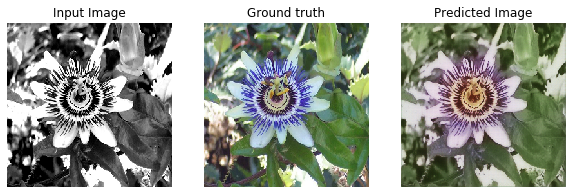

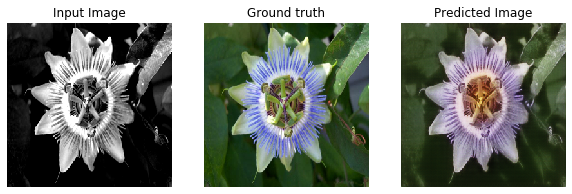

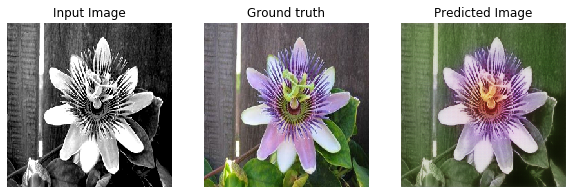

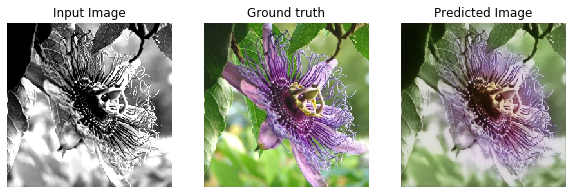

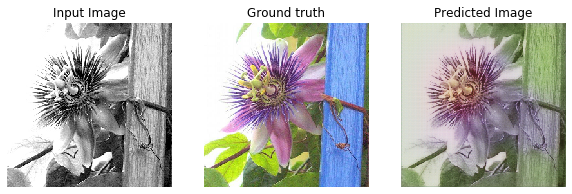

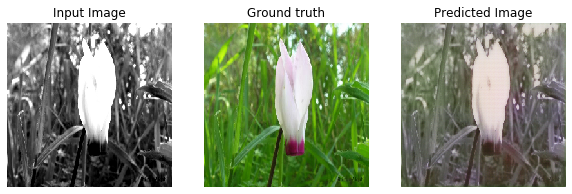

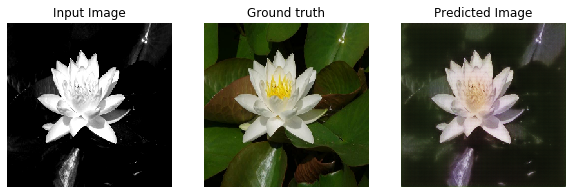

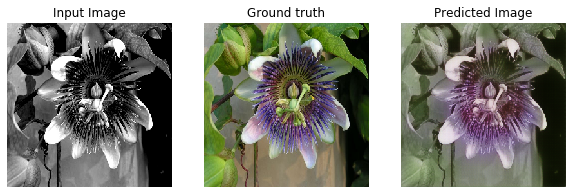

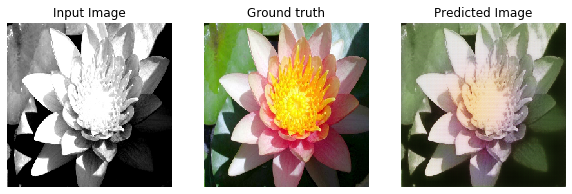

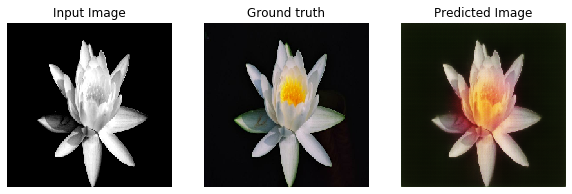

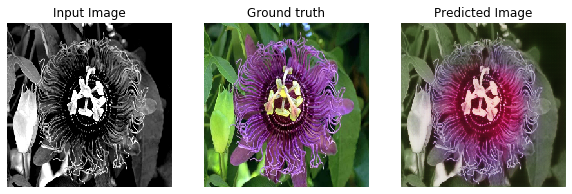

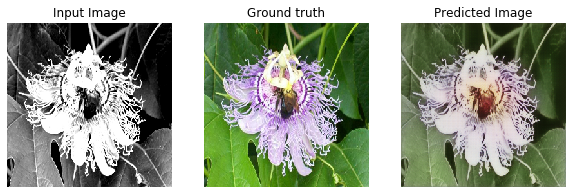

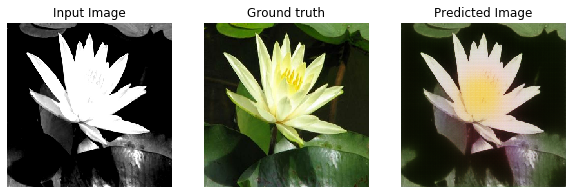

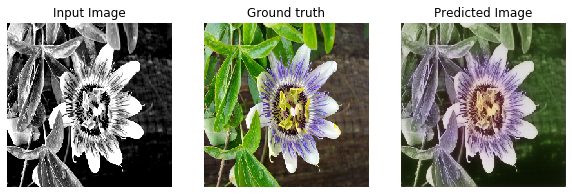

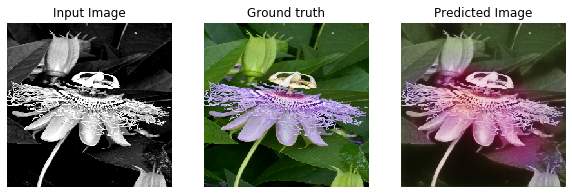

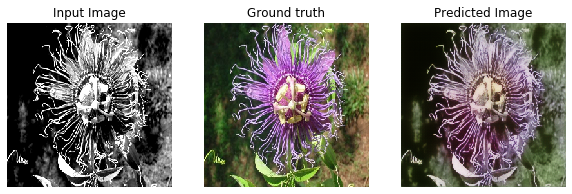

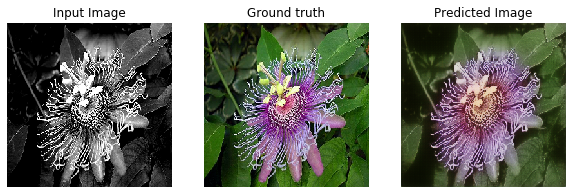

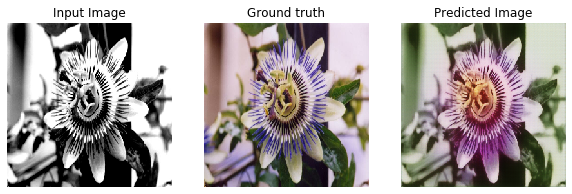

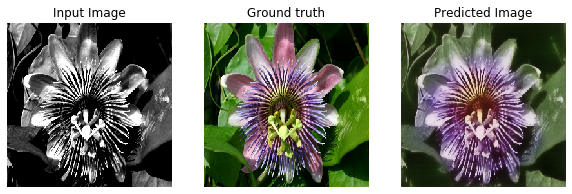

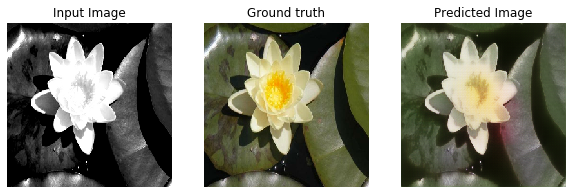

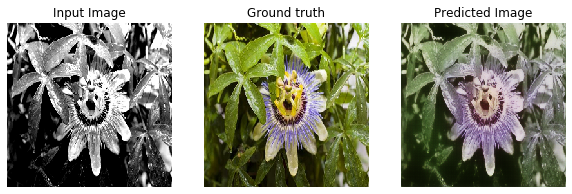

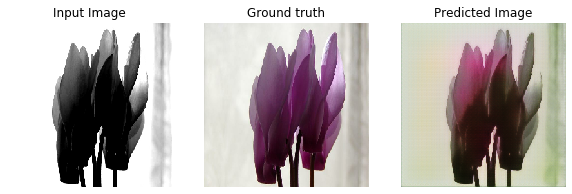

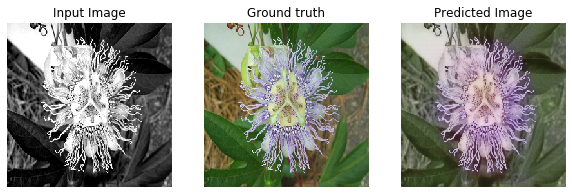

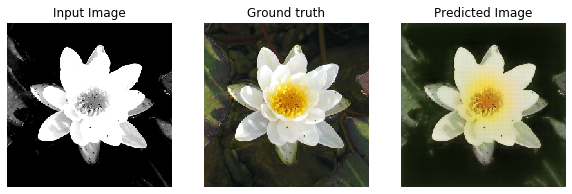

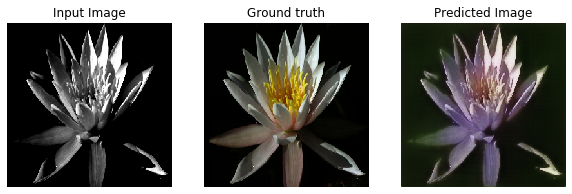

In [ ]:

for inp, tar in test_dataset.take(100):
  generate_images(generator, inp, tar)